<a href="https://colab.research.google.com/github/PedroHenriqueS22/Customer-Clustering-Ecommerce/blob/main/Modelo_analise_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de análise das métricas RFV

## Contexto
Uma empresa de e-commerce está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. A empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, é preciso identificar o perfil dos clientes com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes.

A partir da clusterização, é possível gerar insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

## Sobre os dados

Acesse os dados aqui: https://www.kaggle.com/datasets/carrie1/ecommerce-data

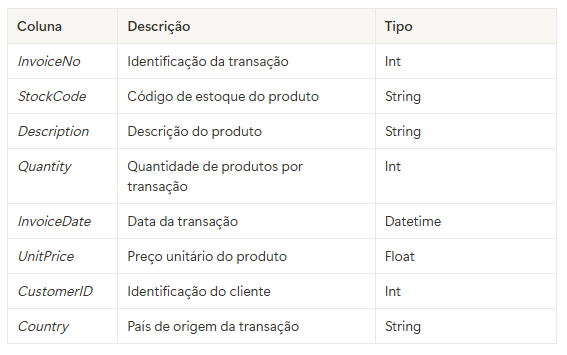

## Etapas

* Análise exploratória dos dados
* Pré-processamento dos dados
* Seleção do algoritmo de clusterização
* Analise dos clusters obtidos
* Interpretação dos resultados obtidos



In [ ]:
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, PowerTransformer
from yellowbrick.cluster import kelbow_visualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## Etapa 01) Análise exploratória dos dados

In [ ]:
# Carregando a base de dados

df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

# Visualizando as primeiras linhas

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Realizando a descrição estatística dos dados

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [ ]:
df[['Description','Country']].nunique()

,0
Description,4223
Country,38


<Axes: ylabel='Country'>

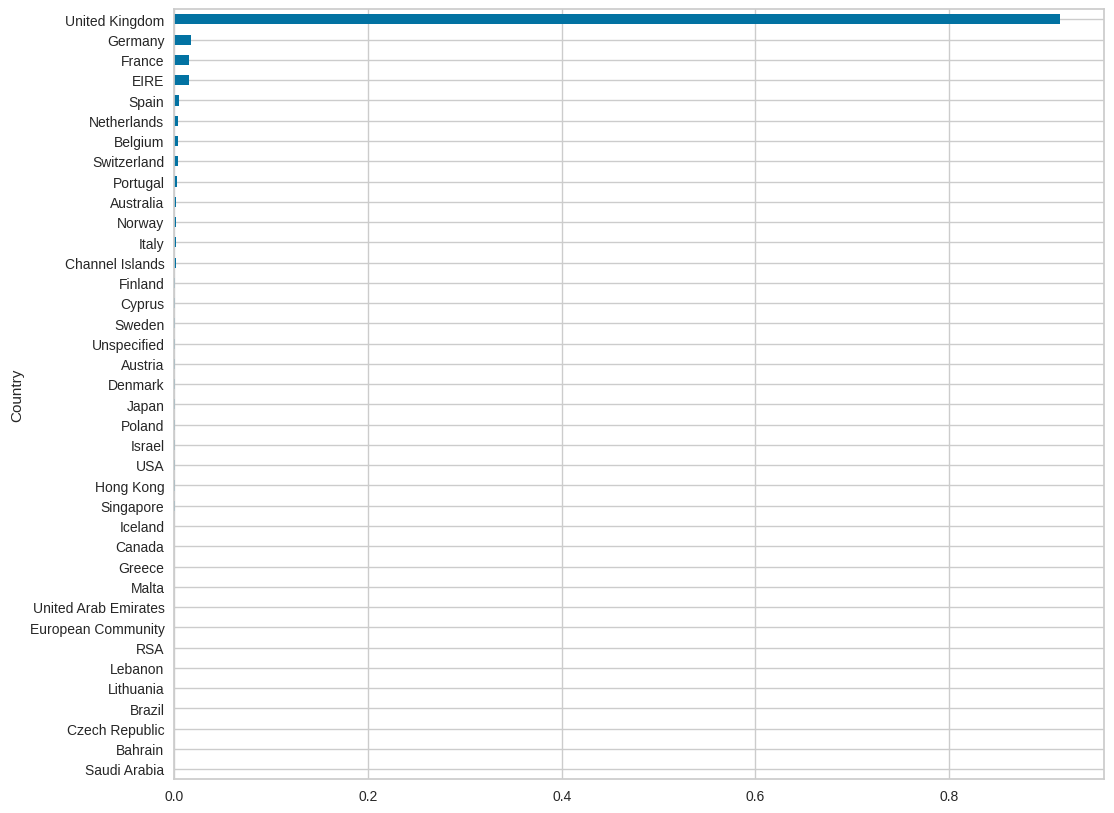

In [ ]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [ ]:
# Verificando a presença de dados nulos e os tipos de variáveis presentes na base de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Verificando a quantidade de varoles faltantes e sua representatividade

df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
CustomerID,135080,24.93%
Description,1454,0.27%
InvoiceNo,0,0.00%
StockCode,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
Country,0,0.00%


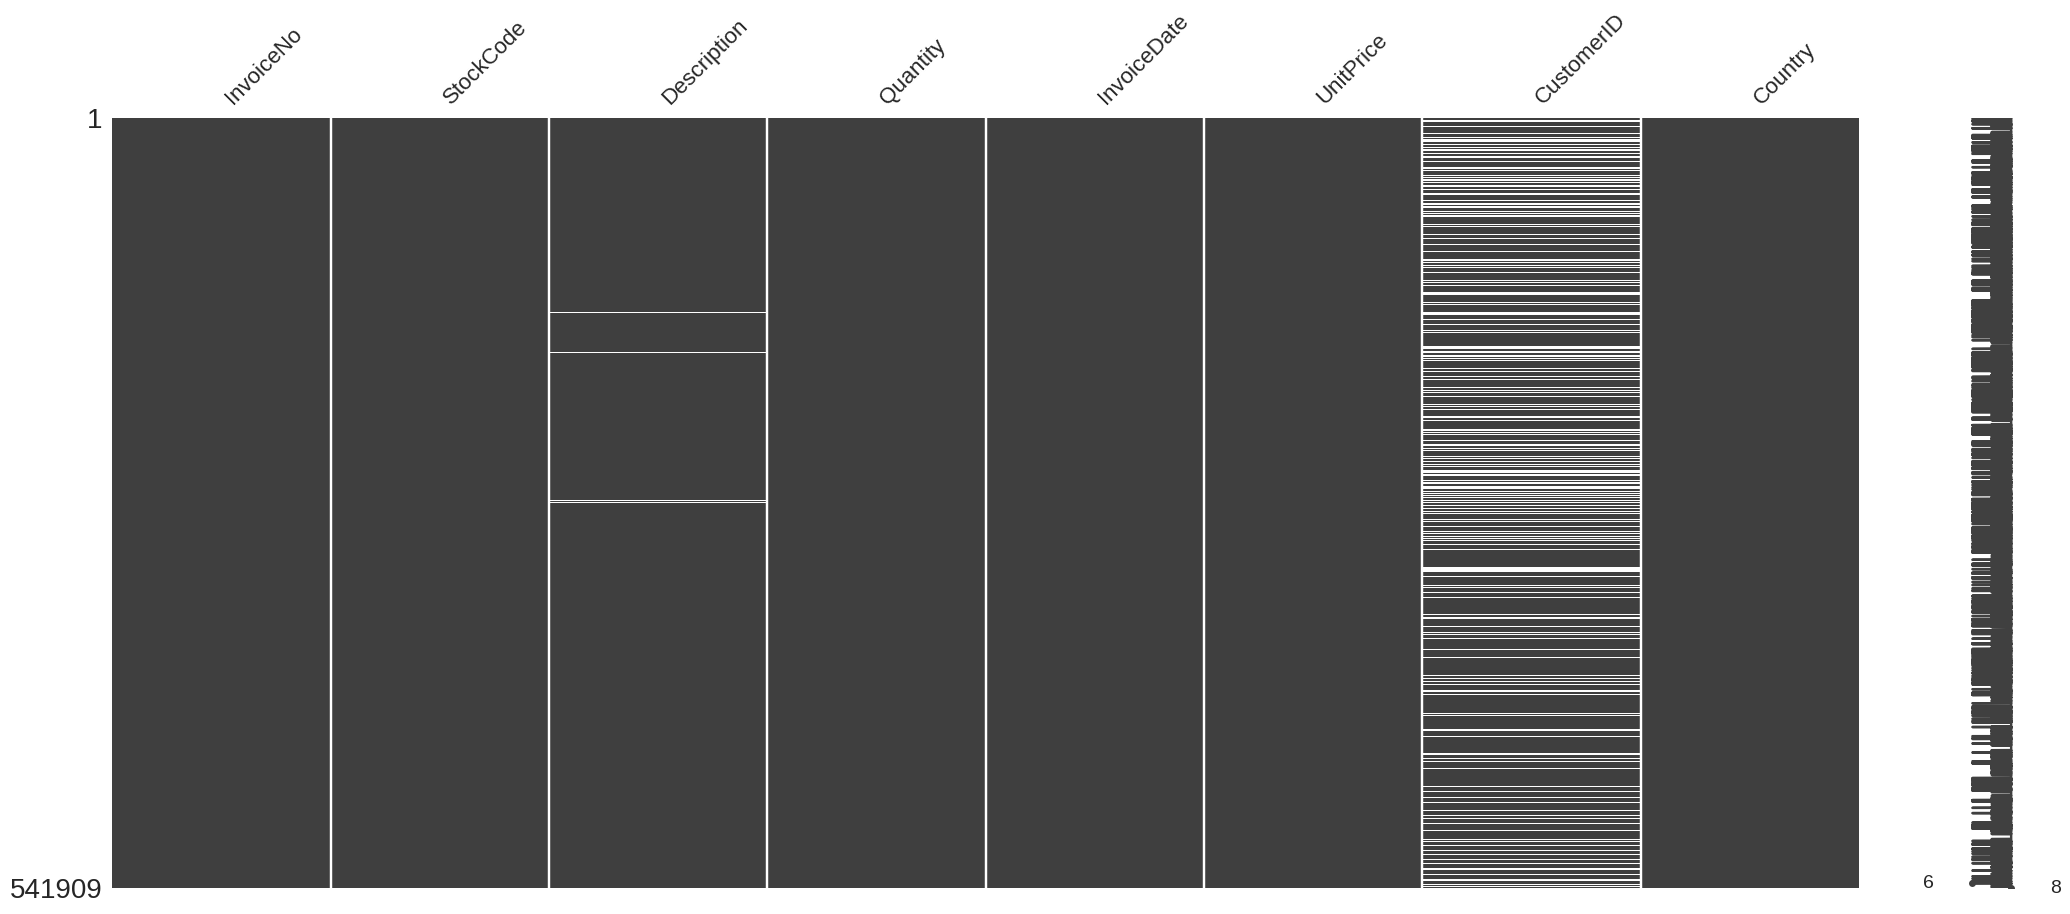

In [ ]:
# Plotando a matrix para melhor visualização das colunas com valores faltantes

msno.matrix(df);

In [ ]:
# Identificar quantos valores duplicados há em cada duplicata
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
)

n_duplicates
InvoiceNo StockCode Description                         Quantity InvoiceDate      UnitPrice CustomerID Country                     
555524    22698     PINK REGENCY TEACUP AND SAUCER       1       6/5/2011 11:37   2.95      16923.0    United Kingdom            20
          22697     GREEN REGENCY TEACUP AND SAUCER      1       6/5/2011 11:37   2.95      16923.0    United Kingdom            12
572861    22775     PURPLE DRAWERKNOB ACRYLIC EDWARDIAN  12      10/26/2011 12:46 1.25      14102.0    United Kingdom             8
541266    21755     LOVE BUILDING BLOCK WORD             1       1/16/2011 16:25  5.95      15673.0    United Kingdom             6
572344    M         Manual                               48      10/24/2011 10:43 1.50      14607.0    United Kingdom             6
...                                                                                                                             ...
556484    22326     ROUND SNACK BOXES SET OF4 WOODLAND   2       6/12/2011 13:17  2.95      16938.0    United Kingdom             2
          22139     RETROSPOT TEA SET CERAMIC 11 PC      1       6/12/2011 13:17  4.95      16938.0    United Kingdom             2
556481    23182     TOILET SIGN OCCUPIED OR VACANT       3       6/12/2011 13:00  0.83      16115.0    United Kingdom             2
556473    22727     ALARM CLOCK BAKELIKE RED             1       6/12/2011 12:00  3.75      17265.0    United Kingdom             2
C580764   22667     RECIPE BOX RETROSPOT                -12      12/6/2011 10:38  2.95      14562.0    United Kingdom             2

[4879 rows x 1 columns]

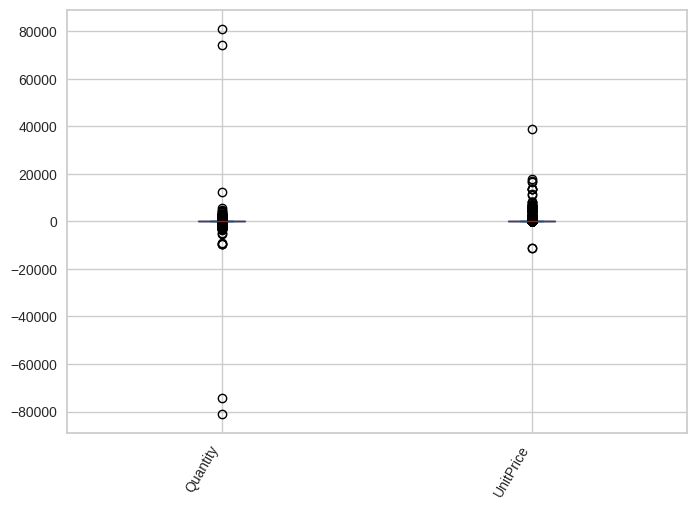

In [ ]:
# Box plot para identificar outliers

df[['Quantity', 'UnitPrice']].plot.box()
plt.xticks(rotation=60, ha='right');

## Etapa 02) Pré-processamento dos dados

In [ ]:
# Removendo dados ausentes
df.dropna(inplace=True)

# Removendo dados duplicados
df.drop_duplicates(inplace=True)

In [ ]:
# Convertendo a coluna de data para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convertendo a coluna de CustomerID para object
df['CustomerID'] = df['CustomerID'].astype('int')

# Adicionando uma coluna de valor total (Quantidade * Preço Unitário)
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Verificando a presença de dados nulos e os tipos de variáveis presentes na base de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  int64         
 7   Country      401604 non-null  object        
 8   Total_Price  401604 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


In [ ]:
# Confirmando que não tem mais valores duplicados
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
)

,,,,,,,,,n_duplicates
InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,


In [ ]:
# Confirmando que não tem mais varoles faltantes

df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
InvoiceNo,0,0.00%
StockCode,0,0.00%
Description,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
CustomerID,0,0.00%
Country,0,0.00%
Total_Price,0,0.00%


In [ ]:
df.InvoiceDate.agg(['min','max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


In [ ]:
# Verificando e retirando os valores que são menores ou iguais a 0

below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

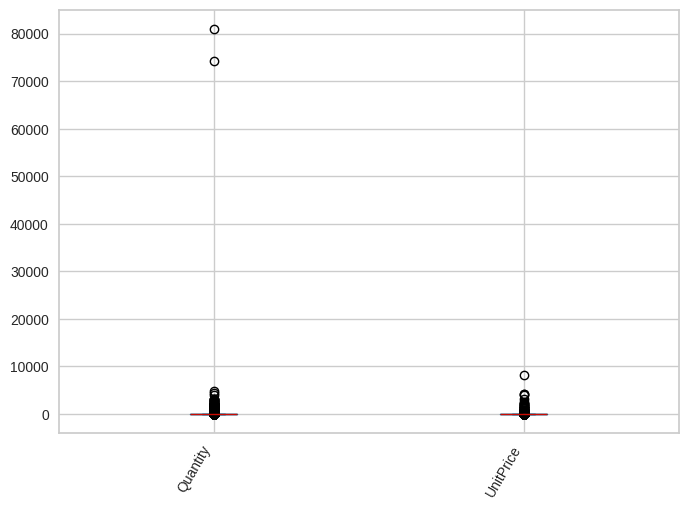

In [ ]:
# Box plot para visualizar os outliers

df[['Quantity', 'UnitPrice']].plot.box()
plt.xticks(rotation=60, ha='right');

<Axes: >

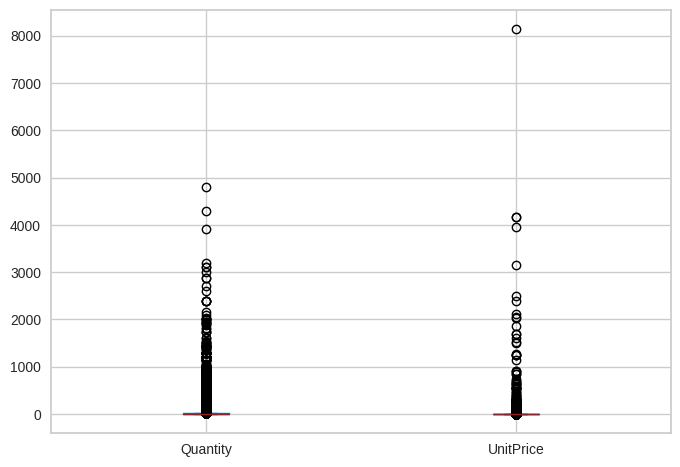

In [ ]:
# Query para visualizar os outliers

df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [ ]:
# Removendo os outliers

df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

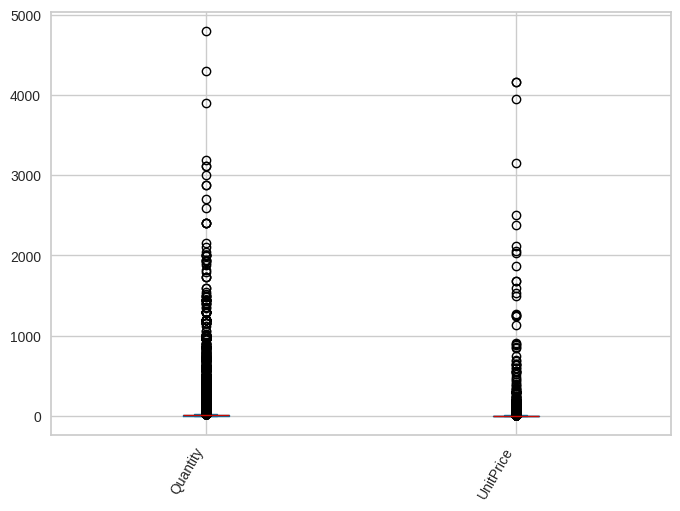

In [ ]:
# Box plot para visualizar sem os outliers

df[['Quantity', 'UnitPrice']].plot.box()
plt.xticks(rotation=60, ha='right');

In [ ]:
pd.Timestamp.today()

Timestamp('2024-11-08 03:14:39.847944')

Criando as métricas RFV:

In [ ]:
df_rfv = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      V = ('Total_Price', 'mean')
  )
)

df_rfv

,R,F,V
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


* Foi utilizado a data 01/01/2012 para que a recência não fique tão alta, então consideraremos, para esse desafio, que estamos fazendo essa análise em 2012




<Axes: >

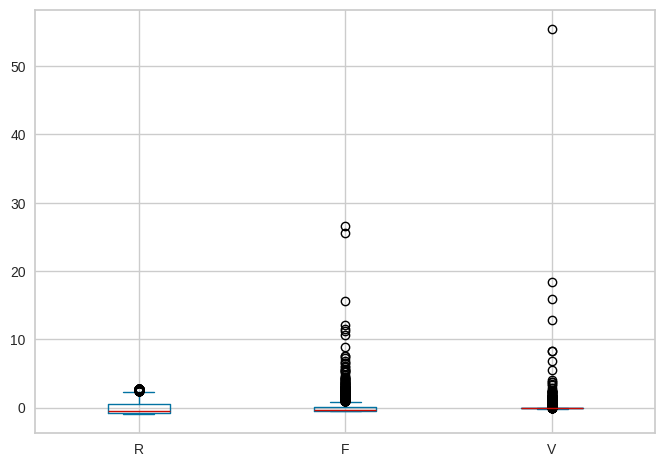

In [ ]:
df_rfv.apply(scale).plot.box()

In [ ]:
df_rfv.apply(scale).query('V>50')

,R,F,V
CustomerID,,,
15098,0.899878,-0.165317,55.434689


In [ ]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


* Os dados referente a esse cliente não estão fazendo sentido, devido as quantidades e preço unitário. Sendo assim irei dropar esse cliente.


In [ ]:
df_rfv = df_rfv.drop(15098)

<Axes: >

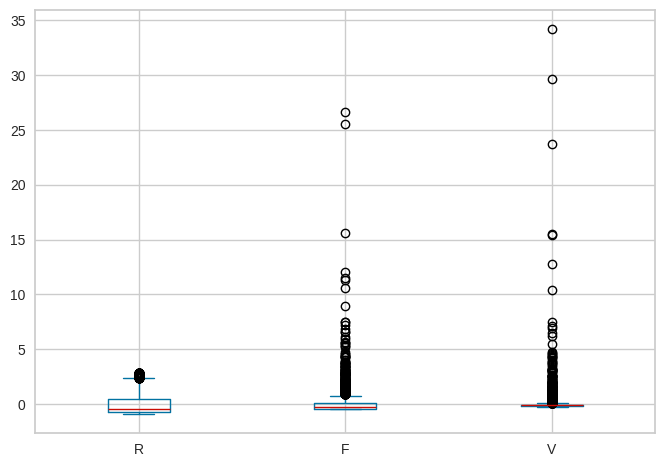

In [ ]:
df_rfv.apply(scale).plot.box()

Fazendo uma normalização

In [ ]:
scaler = PowerTransformer()

In [ ]:
df_rfv_scaled = pd.DataFrame(scaler.fit_transform(df_rfv), index=df_rfv.index, columns=df_rfv.columns)
df_rfv_scaled

,R,F,V
CustomerID,,,
12347,-1.563219,1.201866,0.407173
12348,0.323470,0.660670,1.331122
12349,-0.809134,-1.158070,0.426251
12350,1.568467,-1.158070,0.187636
12352,-0.307718,1.309671,0.653747
...,...,...,...
18280,1.475652,-1.158070,0.083252
18281,1.107356,-1.158070,-0.497128
18282,-1.275046,-0.195707,-0.164818


<Axes: >

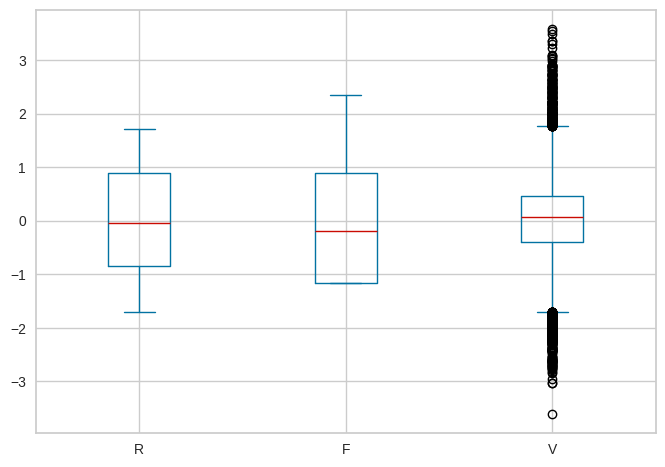

In [ ]:
df_rfv_scaled.plot.box()

In [ ]:
df_rfv.describe()

,R,F,V
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.585253
std,99.968352,7.697927,129.203857
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,395.000000,209.000000,4453.430000


* Atribuindo um valor aceitável para os que tem um valor muito acima. Então se o valor estiver no extremo dos 5% ele será reduzido para que o valor máximo seja do quantil de 95%


In [ ]:
df_rfv_clip = df_rfv.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfv_clip.describe()

,R,F,V
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.662082
std,95.504576,3.358999,20.978901
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,333.000000,13.000000,91.768421


Padronizando utilizando o scale:

In [ ]:
df_rfv_clip_scaled = df_rfv_clip.apply(scale)

## Etapa 03) Seleção do algoritmo de clusterização

O algoritmo de clusterização escolhido é o Kmeans

Para escolher o melhor K irei utilizar o método do cotovelo

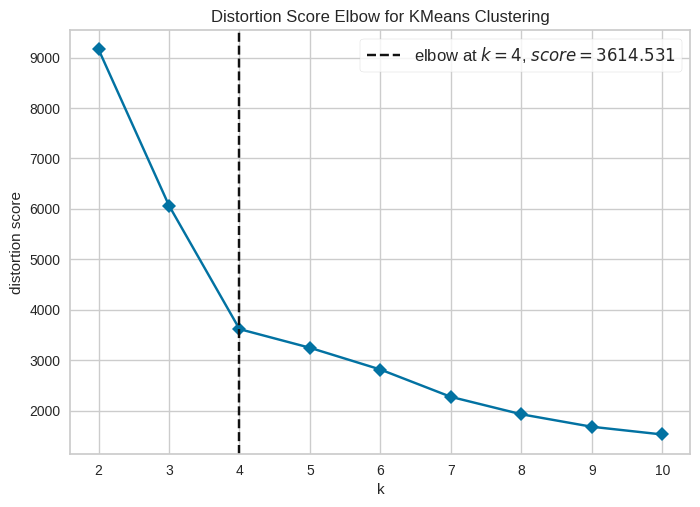

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
kelbow_visualizer(KMeans(), df_rfv_clip_scaled, k=10, timings=False)

Fica evidente que o melhor K é igual a 4

In [ ]:
# Verificando algumas métricas

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfv_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9607.145048,0.481692,1.042416,1534.202439
3,6379.631017,0.395438,0.918546,2250.977458
4,3614.487667,0.479660,0.704316,3752.748844
5,3103.863609,0.386190,0.854429,3454.959599
6,2541.231249,0.397897,0.851011,3566.865109
7,2239.089949,0.402073,0.849264,3470.060263
8,1923.444839,0.390825,0.847351,3563.172646
9,1678.380931,0.400176,0.803116,3651.172116
10,1515.501151,0.351852,0.887849,3645.049413


Com as métricas fica evidente que o K igual a 4 é o melhor, visto que tem o segundo silhouette_score mais alto, o menor davies_bouldin_score e o maior calinski_harabasz_score.

Treinando o modelo KMeans com o número de clusters encontrado:

In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfv_clip_scaled)

Plotando o scatter_3d para visualizar os clusters:

In [ ]:
px.scatter_3d(df_rfv_clip_scaled, x='R', y='F', z='V', color=kmeans_labels.astype(str), template='plotly_dark')

## Etapa 04) Analise os clusters obtidos

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfv_clip_scaled.columns)

Plotando gráfico para identificar padrões:

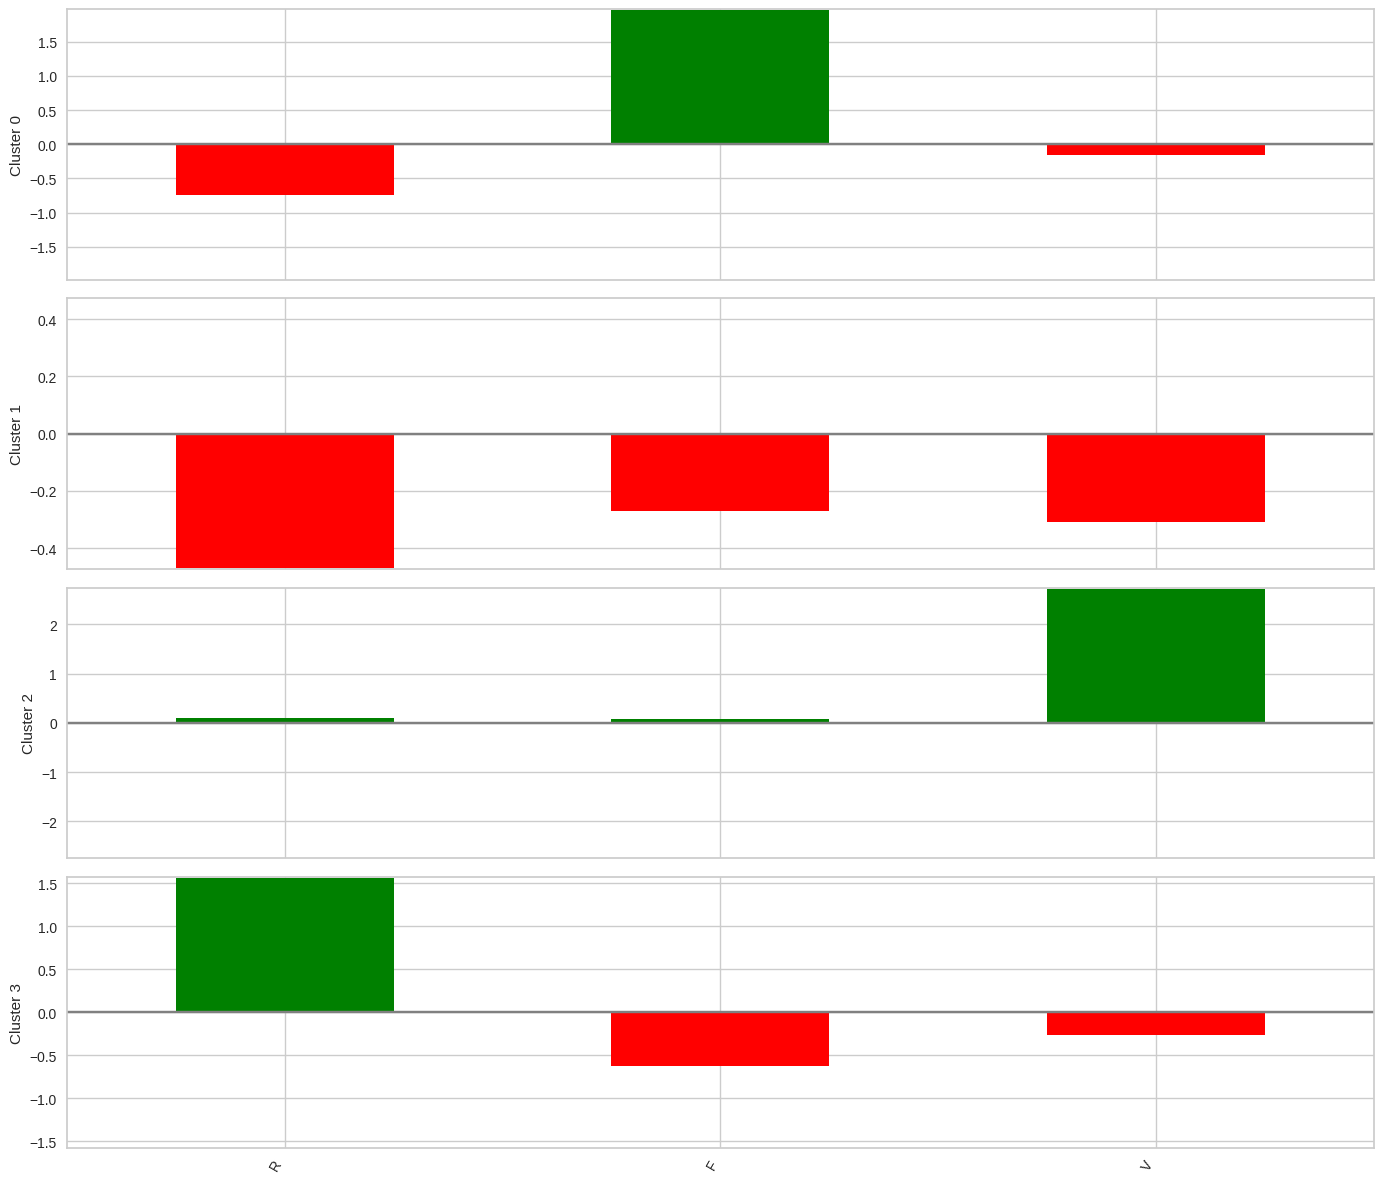

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  df_rfv_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,41.517018,67.523221,121.057935,261.082051
F,10.191248,2.703877,3.876574,1.509744
V,20.467061,17.153676,80.710870,18.121764


Verificando a distribuição de clientes nos grupos:

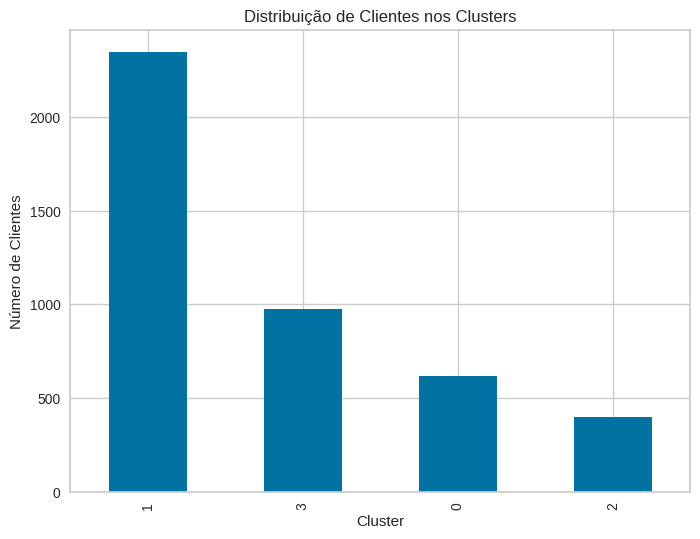

In [ ]:
df_rfv_clip['Cluster'] = kmeans.labels_

plt.figure(figsize=(8, 6))
df_rfv_clip['Cluster'].value_counts().plot(kind='bar')
plt.title('Distribuição de Clientes nos Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.show()

Vendo o RFV médio de cada cluster:

In [ ]:
# Supondo que 'Recency', 'Frequency', 'Monetary' sejam as colunas de RFV
rfv_clusters = df_rfv_clip.groupby('Cluster')[['R', 'F', 'V']].mean()
print(rfv_clusters)

                  R          F          V
Cluster                                  
0         41.517018  10.191248  20.467061
1         67.523221   2.703877  17.153676
2        121.057935   3.876574  80.710870
3        261.082051   1.509744  18.121764


## Etapa 05) Interpretação dos resultados obtidos

Se faz importante ter essa análise para que possamos entender as peculiaridades de cada grupo de clientes, assim podemos criar estrátegias de marketing as quais irão ter uma eficiência mais elevada, pois estarão personalizadas de acordo com as necessidades e comportamentos específicos de cada segmento. A segmentação de clientes, por meio de análise de clusters como o KMeans, permite identificar grupos com características semelhantes, como frequência de compras, recência e valor monetário.

Com base nesses insights, podemos adaptar nossas campanhas para maximizar o impacto, seja por meio de ofertas mais atraentes, mensagens direcionadas ou canais de comunicação preferenciais. Além disso reduziremos os custos e o cliente terá a empresa voltada para a sua necessidade.


### Cluster 0:


* Tem uma frequência bem elevada;
* Tem um ticket médio baixo;
* Tem recência baixa, o que é bom, indica que comprou recente;

* Compra com frequência, a última compra foi recente, porém não tem um ticket médio alto, indicando que não gasta muito com suas compras.

Sugestão: criar programas de fidelidade ou descontos exclusivos. Com base na sua frequência ou no valor gasto (para estimular também o aumento do ticket médio) oferecer benefícios.



### Cluster 1:

* Tem recência baixa, o que é bom, indica que comprou recente;
* Tem uma frequência baixa, indicando que não efetuou muitas compras;
* Tem um ticket médio baixo.


* É possível que seja um novo cliente ou um cliente que fez poucas compras e possa ser que retorne.

Sugestão: Enviar um email automático para o cliente solicitando uma avaliação e, caso ele responda, receba um desconto na próxima compra.

### Cluster 2:

* Tem um ticket médio alto, distoando dos outros clusters;
* Tem uma frequência um pouco elevada;
* Tem uma recência um pouco elevada, indicando que já não faz tanto tempo que compra.


* Cliente que gastou um alto valor, mas com uma menor frequência.

Sugestão: Incentivar compras recorrentes com descontos progressivos. Quando o cliente fizer uma compra ele receberá um desconto especial na segunda compra e assim por diante, para estimular o retorno do mesmo.


### Cluster 3:


* Recência alta, o que indica que a última compra foi a um longo tempo;
* Frequência baixa, indicando que não efetua muitas compras;
* Ticket médio baixo, mostrando que nas compras não gastou muito.

* Aparenta ser um possível churn.

Sugestão: Realizar uma campanha de recuperação de clientes, pode ser enviado para o cliente um e-mail com um desconto esclusivo e com algumas ofertas semelhante as compras já realizadas por ele.